In [44]:
# Bibliotecas
# teste

import pandas as pd
import matplotlib.pyplot as plt
import nltk
import unicodedata
import re
import os
import numpy as np
from collections import Counter
from scipy.spatial.distance import euclidean
import string
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from nltk.corpus import stopwords
nltk.download('stopwords')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import scipy.stats as stats
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /home/ester/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Passo 1: Análise dos Dados

In [2]:
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["Label", "Message"])
# header - cabecalho (None, nao tem cabecalho) #sep \t por se tratar de um arquivo tsv
display(df) #df = data frame


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Label
ham     4825
spam     747
Name: count, dtype: int64


<Axes: title={'center': 'Distribuição de Classes (Ham vs Spam)'}, ylabel='count'>

Text(0, 0.5, '')

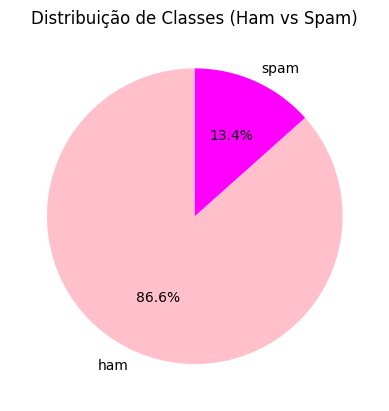

In [3]:
contagem = df['Label'].value_counts()
print(contagem)
contagem.plot(kind='pie', autopct='%1.1f%%', colors=["pink", "magenta"], title="Distribuição de Classes (Ham vs Spam)", startangle=90, legend=False)
plt.ylabel('')
plt.show()

,Label,Message,Word_count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30
5568,ham,Will ü b going to esplanade fr home?,8
5569,ham,"Pity, * was in mood for that. So...any other s...",10
5570,ham,The guy did some bitching but I acted like i'd...,26


<Figure size 1000x600 with 0 Axes>

(array([2.152e+03, 1.661e+03, 1.252e+03, 3.960e+02, 4.600e+01, 2.200e+01,
        1.700e+01, 1.300e+01, 3.000e+00, 4.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180.]),
 <BarContainer object of 18 artists>)

Text(0.5, 1.0, 'Distribuição de Documentos por Número de Palavras')

Text(0.5, 0, 'Número de Palavras')

Text(0, 0.5, 'Número de Documentos')

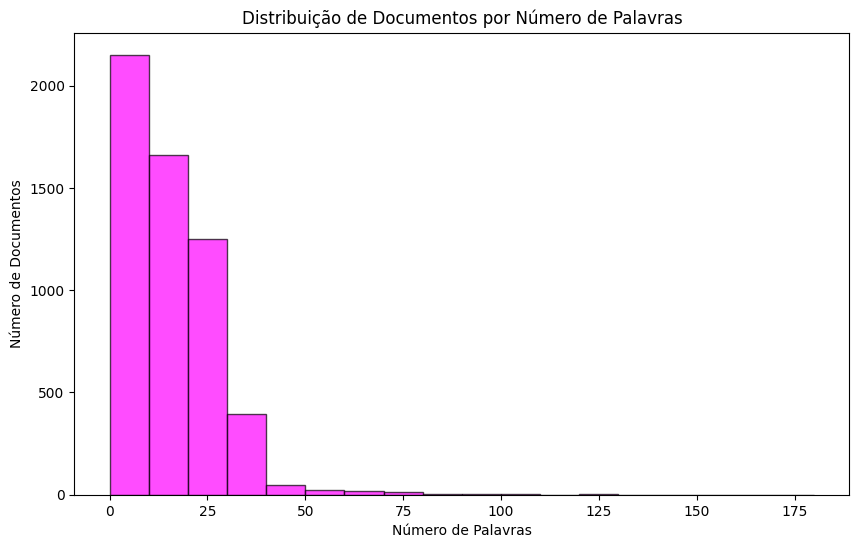

In [4]:
df["Word_count"] = df["Message"].apply(lambda x: len(x.split())) # Número de palavras por documento
# Split divide o texto em palavras usando espaço como separador
display(df)

plt.figure(figsize=(10,6))
plt.hist(df["Word_count"], bins=range(0, df["Word_count"].max() + 10, 10), edgecolor='black', color='magenta', alpha=0.7)

plt.title("Distribuição de Documentos por Número de Palavras")
plt.xlabel("Número de Palavras")
plt.ylabel("Número de Documentos")

plt.show()

In [5]:
df["Word_count"].describe() #Alguns dados
# Count: número de mensagens
# Mean: média de palavras por mensagem
# Std: desvio padrão (o quanto as mensagens variam em relação à média)
# Min: a menor mensagem tem uma palavra
# 25%: 25% das mensagens têm até 7 palavras
# Max: a maior mensagem tem 171 palavras

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: Word_count, dtype: float64

### Passo 2 - Pré-processamento

In [6]:
#Iniciando pré-processamento de Dados (Passo 2)

#Passo 1 - Converter para minúsculas, remover acentuação, e stopwords

def processar_etapa1(texto):
    texto = texto.lower() # Coloca tudo em minúsculo
    
    # remove acentuação
    texto = ''.join( # depois de filtrar, junta tudo de novo em uma string normal
        caractere for caractere in unicodedata.normalize('NFD', texto) # Quebra os caracteres acentuados (ex.: ç = c, cedilha)
        if unicodedata.category(caractere) != 'Mn' # Mn = Mark, Nonspacing (acentos, tils, cedilhas...)
    )
    stopwords_en = set(stopwords.words('english')) 
    tokens = texto.split() # quebra em tokens
    tokens = [t for t in tokens if t not in stopwords_en]

    return ' '.join(tokens) # junta novamente em uma string

df["Message_clean"] = df["Message"].apply(processar_etapa1)

In [7]:
# Passo 2 - Remoção de marcações
df["Message_clean"] = df["Message_clean"].apply(lambda x: re.sub(r"[@#][\w@]+", "", x))
# r"[@#]\w+" -> busca o que deve ser removido
# "" -> o que deve ser substituído (nada)

In [8]:
# Passo 4: remover urls (http e www)

def remover_urls(texto):
    return re.sub(r'(http[s]?://\S+|www\.\S+)', '', texto, flags=re.IGNORECASE)
    # re.sub (padrao, substituo, texto)
    # http\S+ -> pega tudo que comeca com http e segue com qualquer coisa que nao seja espaço
    # www\.\S+ -> pega tudo que comeca com www. seguido pos algo que nao seja espaço

df["Message_clean"] = df["Message_clean"].apply(remover_urls)

In [9]:
# Passo 3 - Reduzir repetições (máximo duas ocorrências)
# Exemplo: boaaaaaaa -> boaa

def reduzir_repeticoes(texto):
    return re.sub(r'(.)\1{2,}', r'\1\1', texto)
    # (.) -> captura qualquer caractere
    # \1 refere-se ao mesmo caractere capturado
    # {2,} -> casa com duas ou mais repetições do mesmo caractere
    # r'\1\1 -> substitui por duas ocorrencias desse caractere

df["Message_clean"] = df["Message_clean"].apply(reduzir_repeticoes)

In [10]:
# Passo 5: remover pontuação

df["Message_clean"] = df["Message_clean"].str.translate(str.maketrans('', '', string.punctuation))

In [ ]:
# Passo 6: remover entidades referentes à localizações e organizações
#Esse caso é para textos em inglês

nlp = spacy.load("en_core_web_sm")

entidades_para_remover = {"ORG", "GPE", "LOC"}

def remover_entidades(texto):
    doc = nlp(texto)
    indices_para_remover = set()
    
    for ent in doc.ents:
        if ent.label_ in entidades_para_remover:
            for token in ent:
                indices_para_remover.add(token.i)
    
    tokens_filtrados = [token.text for i, token in enumerate(doc) if i not in indices_para_remover]
    return " ".join(tokens_filtrados)

df["Message_clean"] = df["Message_clean"].apply(remover_entidades)

In [12]:
# Etapa 7: remover tokens numéricos

def remover_tokens_numericos(texto):
    tokens = texto.split()
    tokens_sem_numeros = [t for t in tokens if not re.search(r'\d', t)]
    return ' '.join(tokens_sem_numeros)

df["Message_clean"] = df["Message_clean"].apply(remover_tokens_numericos)

In [13]:
# Etapa 8: remover palavras com menos de 3 caracteres

def remover_palavras_curtas(texto):
    tokens = texto.split()
    tokens_sem_palavras_curtas = [t for t in tokens if len(t) >= 3]
    return ' '.join(tokens_sem_palavras_curtas)

df["Message_clean"] = df["Message_clean"].apply(remover_palavras_curtas)

In [ ]:
# Etapa 9: remover nomes pessoais

nlp = spacy.load("en_core_web_sm")

def remover_nomes_pessoais(texto):
    doc = nlp(texto)
    texto_sem_nomes = [token.text for token in doc if token.ent_type_ != "PERSON"]
    return " ".join(texto_sem_nomes)

df["Message_clean"] = df["Message_clean"].apply(remover_nomes_pessoais)

In [ ]:
# Lematização

nlp = spacy.load("en_core_web_sm")

def lematizacao(texto):
    doc = nlp(texto)
    tokens_lematizados = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens_lematizados)

df["Message_clean"] = df["Message_clean"].apply(lematizacao)

In [16]:
df_clean = df.copy()

,Label,Message,Word_count,Message_clean,Word_count_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,crazy available bugis great world buffet cine ...,10
1,ham,Ok lar... Joking wif u oni...,6,lar joke wif oni,4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts text r...,15
3,ham,U dun say so early hor... U c already then say...,11,early hor,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think go usf life,5
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time try contact pound prize claim easy minute...,9
5568,ham,Will ü b going to esplanade fr home?,8,go esplanade home,3
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood soany suggestion,4
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching act like interested buy week give...,9


<Figure size 1000x600 with 0 Axes>

(array([4.283e+03, 1.223e+03, 4.900e+01, 8.000e+00, 6.000e+00, 3.000e+00]),
 array([ 0., 10., 20., 30., 40., 50., 60.]),
 <BarContainer object of 6 artists>)

Text(0.5, 1.0, 'Distribuição de Documentos por Número de Palavras')

Text(0.5, 0, 'Número de Palavras')

Text(0, 0.5, 'Número de Documentos')

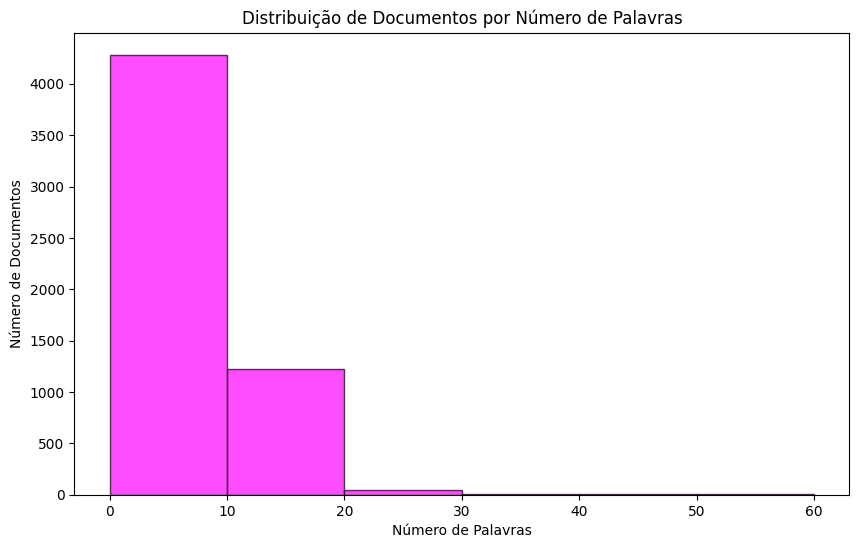

In [17]:
df_clean["Word_count_clean"] = df_clean["Message_clean"].apply(lambda x: len(x.split())) # Número de palavras por documento
display(df_clean)

plt.figure(figsize=(10,6))
plt.hist(df_clean["Word_count_clean"], bins=range(0, df_clean["Word_count_clean"].max() + 10, 10), edgecolor='black', color='magenta', alpha=0.7)

plt.title("Distribuição de Documentos por Número de Palavras")
plt.xlabel("Número de Palavras")
plt.ylabel("Número de Documentos")

plt.show()


In [18]:
df_clean.to_csv("df_ex1_clean.csv", index=False)

### Passo 3: Representação TF-IDF

In [19]:
# Passo 3: Representação TF-IDF 
df_tfidf = df_clean.copy()

X = df_tfidf["Message_clean"] # Dados de entrada, mensagens pré-processadas
y = df_tfidf["Label"] # Rótulos ham ou spam

codificador = LabelEncoder()
y_codificado = codificador.fit_transform(y) # Convertendo rótulos textuais para inteiros
# ham = 0, spam = 1

# Dividindo em 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y_codificado, test_size=0.2, random_state=0)

# Criando o vetor TF-IDF para converter texto em vetores numéricos
vectorizer = TfidfVectorizer()

# Apredne o vocabulário com base no treino e transforma em vetores TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)

# Somente aplica o vocabulário aprendido com X_train para transformar os dados de teste
X_test_tfidf = vectorizer.transform(X_test)
# Ou seja, palavras que aparecem só em X_test serão ignoradas

print("Vocabulário:", vectorizer.get_feature_names_out()[:20])
print(X_train_tfidf.toarray())
print(X_test_tfidf.toarray())


Vocabulário: ['aah' 'aaooright' 'aathilove' 'aathiwhere' 'abelu' 'aberdeen' 'abi'
 'ability' 'abiola' 'abj' 'able' 'abroad' 'absence' 'abstract' 'abt'
 'abta' 'aburo' 'abuser' 'academic' 'acc']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Passo 4: Classificação

In [20]:
# Passo 4 - Classificação
# Árvore de decisão

def arvore_de_decisao(X_train, y_train, X_test, y_test):
    parametros = {
        'criterion': ['gini', 'entropy'], # Função usada para medir a qualidade de uma divisão
        'max_depth': [None, 10, 20], # Profundidade máxima 
        'min_samples_split': [2, 5, 10], # Mínimo de amostras exigido para dividir um nó
        'min_samples_leaf': [1, 2, 4] # Mínimo de amostras exigido em um nó folha
    }

    # Treinando a árvore de decisão
    clf = tree.DecisionTreeClassifier()

    grid_search = GridSearchCV(estimator=clf, param_grid=parametros, cv=5, scoring='accuracy')
    #cv =5 significa que os dados sao divididos em 5 partes. O modelo é treinado 5 vezes, utilizando 4 partes
    # para treino.

    grid_search.fit(X_train, y_train) # Treina o modelo utilizando os melhores parametros encontrados

    print("Melhores parâmetros: ", grid_search.best_params_)

    melhor_clf = grid_search.best_estimator_ # treina novamente com os melhores parametros
    y_pred = melhor_clf.predict(X_test) # Fazendo a previsão no conjunto de teste

    acuracia = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"\nAcurácia com os melhores parâmetros: {acuracia}")
    print(f"F1 Score (macro) com os melhores parâmetros: {f1_macro}")

    #plt.figure(figsize=(20,10))
    #tree.plot_tree(melhor_clf, max_depth=2, feature_names=vectorizer.get_feature_names_out(), class_names=codificador.classes_, filled=True)
    #plt.show()
    # max_depth profundidade da árvore
    # filled=True colore os nós de acordo com a classe predominante
    # feature_names mostra quais palavras sao mais importantes para as decisoes

    return grid_search.best_params_


In [21]:
# Explicando a árvore exibida
# call <= 0.108 Critério de divisão: se a frequência da palavra "call" for menor ou igual a 0.108 vai para a esquerda (mais provável ser ham)
# gini = 0.229 Medida de impureza do nó. Quanto menor, mais concentrado em uma única classe.
# samples = 4457 Quantidade de mensagens analisadas nese nó
# value = [3870, 587] 3870 são ham e 587 são spam

# Laranja: a classe predominante é ham, Azul: spam. Quanto mais intensa a cor, contém mais exemplos da mesma classe

In [22]:
# KNN - K-Nearest Neighbor

def knn(X_train, y_train, X_test, y_test):
    parametros = {'n_neighbors': [1, 3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']}

    # Aplicando KNN
    knn = KNeighborsClassifier()

    grid_search = GridSearchCV(estimator=knn, param_grid=parametros, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train) # Treina o modelo com diferentes combinações
    print("Melhores parâmetros: ", grid_search.best_params_)

    melhor_knn = grid_search.best_estimator_
    melhor_y_pred = melhor_knn.predict(X_test) # Realiza predições com o modelo ajustado

    acuracia = accuracy_score(y_test, melhor_y_pred)
    f1_macro = f1_score(y_test, melhor_y_pred, average='macro')

    print(f"Acurácia com os melhores parâmetros: {acuracia}")
    print(f"F1 Score (macro) com os melhores parâmetros: {f1_macro}")

    return grid_search.best_params_



In [ ]:
# KNN - na mão

def knn_manual(X_train, y_train, X_test, y_test, k):

    # Calcula a distância euclidiana entre dois vetores 
    def distancia_euclidiana(x1, x2):
        # Converte as duas entradas para arrays densos 1D
        return euclidean(x1.toarray().flatten(), x2.toarray().flatten())

    # Retorna a classe prevista para um exemplo de teste com base nos k vizinhos mais próximos
    def classe_prevista(X_train, y_train, X_test, k):
        distancias = []

        # Calcula a distância entre o exemplo de teste e todos os outros exemplos de treino
        for i in range(X_train.shape[0]):
            distancia = distancia_euclidiana(X_test, X_train[i])
            distancias.append((distancia, y_train[i]))

        distancias.sort(key=lambda x: x[0]) # Ordena pela menor distância
        k_neighboors = distancias[:k] # Seleciona os k mais próximos
        classes = [label for _, label in k_neighboors]
        classe_mais_frequente = Counter(classes).most_common(1)

        return classe_mais_frequente[0][0]

    def avaliacao_knn(X_train, y_train, X_test, y_test, k):
        certo = 0 # Contador de predições corretas

        # Para cada teste, compara com o rótulo verdadeiro
        for i in range(X_test.shape[0]):
            pred = classe_prevista(X_train, y_train, X_test[i], k)
            if pred == y_test[i]:
                certo += 1

        acuracia = certo / X_test.shape[0]
        print(f"Acurácia com K={k}: {acuracia}")
        return acuracia

    avaliacao_knn(X_train, y_train, X_test, y_test, k=5)

In [ ]:
# SVM 

def svm_modelo(X_train, y_train, X_test, y_test):
    parametros = {
        'C': [1, 10],  # Parâmetro C
        'gamma': [0.1, 'auto', 'scale'],  # Parâmetro gamma
        'kernel': ['rbf', 'linear']  # Tipos de kernel
    }
    # Parâmetro C pequeno tolera mais erros (evita overfitting) - está com valor padrão
    # Parâmetro gamma pequeno define que cada ponto de treino tem influencia ampla resultando em 
    # uma fronteira maior - está com valor padrão

    svc = svm.SVC()

    grid_search = GridSearchCV(estimator=svc, param_grid=parametros, cv=5, scoring='accuracy')

    grid_search.fit(X_train, y_train)

    print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

    # Fazendo a previsão com os melhores parametros
    melhor_svm = grid_search.best_estimator_
    y_pred = melhor_svm.predict(X_test)

    print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"F1-Score Macro: {f1_macro}")

    return grid_search.best_params_




In [25]:
def calcular_intervalo_confianca(valores):
    media = np.mean(valores)
    desvio_padrao = np.std(valores)
    n = len(valores)

    t_critico = stats.t.ppf(0.975, df=n-1) # t Student (95% de confiança)

    erro_padrao = desvio_padrao/np.sqrt(n)

    intervalo_confianca = t_critico * erro_padrao

    return media, desvio_padrao, intervalo_confianca

def comparar_modelos_teste_t(resultados):
    # Converte as chaves do dicionário 'resultados' em uma lista de modelos
    modelos = list(resultados.keys())
    acuracias = [resultados[modelo] for modelo in modelos]

    comparacoes = []
    valores_p = []

    # Comparar todos os pares de modelos com o teste t
    for i in range(len(modelos)):
        for j in range(i+1, len(modelos)):
            # Realiza o Teste T entre os dois modelos e extrai o valor p
            _, valor_p = stats.ttest_ind(acuracias[i], acuracias[j])
            comparacoes.append(((modelos[i], modelos[j]), valor_p))
            print(f"Teste T entre {modelos[i]} e {modelos[j]}: valor_p = {valor_p:.4f}")

    # Correção de Bonferroni: ajusta o valor p para múltiplas comparações
    bonferroni_valores_p = [p * len(comparacoes) for p in comparacoes]

    # Loop para exibir os valores p corrigidos pelo método de Bonferroni
    for idx, ((modelo1, modelo2), valor_p) in enumerate(comparacoes):
        p_corrigido = valor_p * len(comparacoes)
        print(f"P-value corrigido Bonferroni ({modelo1} vs {modelo2}): {p_corrigido:.4f}")
        if p_corrigido < 0.05:
            print("Os métodos são estatisticamente diferentes.")
        else:
            print("Os métodos são estatisticamente equivalentes.")

### Passo 6: Qual o melhor classificador? Utilizando Holdout e K fold

In [26]:
# Holdout

def holdout(modelo_cls, X, y, rep, test_size=0.2, best_params=None):
    print("\n --- Holdout --- ")
    acuracias = []
    f1_scores = []

    for i in range(rep):
        print(f"\nRepetição {i}:")

        # Divide os dados diretamente
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        # Instancia o modelo com os melhores parâmetros (se houver)
        modelo = modelo_cls(**best_params) if best_params else modelo_cls()

        # Treinamento e predição
        modelo.fit(X_train_tfidf, y_train)
        y_pred = modelo.predict(X_test_tfidf)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        acuracias.append(acc)
        f1_scores.append(f1)

        print(f"  Acurácia: {acc}")
        print(f"  F1 Score (macro): {f1}")

    print("\nMÉDIA FINAL HOLDOUT:")
    acuracia_media, acuracia_desvio, acuracia_ic = calcular_intervalo_confianca(acuracias)
    f1_media, f1_desvio, f1_ic = calcular_intervalo_confianca(f1_scores)

    print(f"  Acurácia média após Holdout: {acuracia_media:.4f} (± {acuracia_ic:.4f})")
    print(f"  Desvio padrão da Acurácia: {acuracia_desvio:.4f}")
    print(f"  F1 Score (macro) médio: {f1_media:.4f} (± {f1_ic:.4f})")
    print(f"  Desvio padrão do F1 Score (macro): {f1_desvio:.4f}")

    return acuracias, f1_scores


In [27]:
# Stratified K Fold

def stratified_k_fold(modelo, X, y, best_params, k=10):
    print("\n --- Stratified K Fold ---")
    skf = StratifiedKFold(n_splits=k)
    acuracias = []
    f1_scores = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {i}:")
        
        # Dividindo os dados em treino e teste
        X_fold_train, X_fold_test = X[train_idx], X[test_idx]
        y_fold_train, y_fold_test = y[train_idx], y[test_idx]

        X_fold_train_tfidf = vectorizer.fit_transform(X_fold_train)
        X_fold_test_tfidf = vectorizer.transform(X_fold_test)

        # Inicializando o modelo com os melhores parâmetros
        clf_fold = modelo(**best_params) if (best_params) else modelo()
        
        # Treinando o modelo
        clf_fold.fit(X_fold_train_tfidf, y_fold_train)

        # Predição
        y_pred_fold = clf_fold.predict(X_fold_test_tfidf)

        # Calculando as métricas
        acc = accuracy_score(y_fold_test, y_pred_fold)
        f1 = f1_score(y_fold_test, y_pred_fold, average='macro')

        # Armazenando os resultados
        acuracias.append(acc)
        f1_scores.append(f1)

        # Exibindo os resultados por fold
        print(f"  Acurácia do Fold {i}: {acc}")
        print(f"  F1 Score (macro) do Fold {i}: {f1}")

    acuracia_media, acuracia_desvio, acuracia_ic = calcular_intervalo_confianca(acuracias)
    f1_media, f1_desvio, f1_ic = calcular_intervalo_confianca(f1_scores)

    # Exibindo as métricas médias
    print(f"\nAcurácia média após K-Fold: {acuracia_media:.4f} (± {acuracia_ic:.4f})")
    print(f"F1 Score (macro) médio após K-Fold: {f1_media:.4f} (± {f1_ic:.4f})")
    print(f"  Desvio padrão da Acurácia: {acuracia_desvio:.4f}")
    print(f"  Desvio padrão do F1 Score (macro): {f1_desvio:.4f}")

    return acuracias, f1_scores


In [28]:
# Concatenando treino e teste novamente para o KFold (reutilizando o vetor completo)

print("\n--- ÁRVORE DE DECISÃO ---")
melhores_parametros_arvore = arvore_de_decisao(X_train_tfidf, y_train, X_test_tfidf, y_test)
resultados_arvore_k_fold = stratified_k_fold(DecisionTreeClassifier, X, y_codificado, melhores_parametros_arvore, 10)
resultados_arvore_holdout = holdout(DecisionTreeClassifier, X, y_codificado, 3, 0.2, melhores_parametros_arvore)



--- ÁRVORE DE DECISÃO ---
Melhores parâmetros:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Acurácia com os melhores parâmetros: 0.9704035874439462
F1 Score (macro) com os melhores parâmetros: 0.9393243307866976

 --- Stratified K Fold ---
Fold 0:
  Acurácia do Fold 0: 0.9605734767025089
  F1 Score (macro) do Fold 0: 0.9143120393120393
Fold 1:
  Acurácia do Fold 1: 0.9605734767025089
  F1 Score (macro) do Fold 1: 0.9133173280610083
Fold 2:
  Acurácia do Fold 2: 0.9622980251346499
  F1 Score (macro) do Fold 2: 0.9114969923958688
Fold 3:
  Acurácia do Fold 3: 0.9605026929982047
  F1 Score (macro) do Fold 3: 0.9122709049255441
Fold 4:
  Acurácia do Fold 4: 0.9694793536804309
  F1 Score (macro) do Fold 4: 0.9326073805202661
Fold 5:
  Acurácia do Fold 5: 0.9497307001795332
  F1 Score (macro) do Fold 5: 0.8827438951040538
Fold 6:
  Acurácia do Fold 6: 0.9569120287253142
  F1 Score (macro) do Fold 6: 0.9042955326460481
Fold 7:
  Acurácia do Fol

In [29]:
print("\n--- KNN ---")
melhores_parametros_knn = knn(X_train_tfidf, y_train, X_test_tfidf, y_test)
resultados_knn_k_fold = stratified_k_fold(KNeighborsClassifier, X, y_codificado, melhores_parametros_knn or {}, 10)
resultados_knn_holdout = holdout(KNeighborsClassifier, X, y_codificado, 3, 0.2, melhores_parametros_knn) 



--- KNN ---
Melhores parâmetros:  {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Acurácia com os melhores parâmetros: 0.9587443946188341
F1 Score (macro) com os melhores parâmetros: 0.9066327347925496

 --- Stratified K Fold ---
Fold 0:
  Acurácia do Fold 0: 0.9587813620071685
  F1 Score (macro) do Fold 0: 0.899201244080017
Fold 1:
  Acurácia do Fold 1: 0.9587813620071685
  F1 Score (macro) do Fold 1: 0.8978209119208935
Fold 2:
  Acurácia do Fold 2: 0.9497307001795332
  F1 Score (macro) do Fold 2: 0.8692488262910798
Fold 3:
  Acurácia do Fold 3: 0.9569120287253142
  F1 Score (macro) do Fold 3: 0.8926161557740505
Fold 4:
  Acurácia do Fold 4: 0.947935368043088
  F1 Score (macro) do Fold 4: 0.8674821359717129
Fold 5:
  Acurácia do Fold 5: 0.9443447037701975
  F1 Score (macro) do Fold 5: 0.8583429729352793
Fold 6:
  Acurácia do Fold 6: 0.9533213644524237
  F1 Score (macro) do Fold 6: 0.8836675020885547
Fold 7:
  Acurácia do Fold 7: 0.9587073608617595
  F1 Score (macro) d

In [30]:
print("\n--- SVM ---")
melhores_parametros_svm = svm_modelo(X_train_tfidf, y_train, X_test_tfidf, y_test)
resultados_svm_k_fold = stratified_k_fold(SVC, X, y_codificado, melhores_parametros_svm, 10)
resultados_svm_holdout = holdout(SVC, X, y_codificado, 3, 0.2, melhores_parametros_svm)



--- SVM ---
Melhores parâmetros encontrados: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Acurácia: 0.9757847533632287
F1-Score Macro: 0.949556725853665

 --- Stratified K Fold ---
Fold 0:
  Acurácia do Fold 0: 0.9838709677419355
  F1 Score (macro) do Fold 0: 0.9647437922537436
Fold 1:
  Acurácia do Fold 1: 0.9767025089605734
  F1 Score (macro) do Fold 1: 0.9484782840299727
Fold 2:
  Acurácia do Fold 2: 0.9712746858168761
  F1 Score (macro) do Fold 2: 0.933832264195771
Fold 3:
  Acurácia do Fold 3: 0.9784560143626571
  F1 Score (macro) do Fold 3: 0.9515736393670666
Fold 4:
  Acurácia do Fold 4: 0.9784560143626571
  F1 Score (macro) do Fold 4: 0.9515736393670666
Fold 5:
  Acurácia do Fold 5: 0.9694793536804309
  F1 Score (macro) do Fold 5: 0.930980443608639
Fold 6:
  Acurácia do Fold 6: 0.9748653500897666
  F1 Score (macro) do Fold 6: 0.9435025792615777
Fold 7:
  Acurácia do Fold 7: 0.9748653500897666
  F1 Score (macro) do Fold 7: 0.9435025792615777
Fold 8:
  Acurácia do Fold 8: 0.98204667

In [31]:
print("Testes Houldout: ")

resultados_comparacao_houldout = {
    'Árvore de Decisão': resultados_arvore_holdout[0],
    'KNN': resultados_knn_holdout[0],
    'SVM': resultados_svm_holdout[0]
}

comparar_modelos_teste_t(resultados_comparacao_houldout)

print("Testes K fold: ")

resultados_comparacao_k_fold = {
    'Árvore de Decisão': resultados_arvore_k_fold[0],
    'KNN': resultados_knn_k_fold[0],
    'SVM': resultados_svm_k_fold[0]
}

comparar_modelos_teste_t(resultados_comparacao_k_fold)

Testes Houldout: 
Teste T entre Árvore de Decisão e KNN: valor_p = 0.3669
Teste T entre Árvore de Decisão e SVM: valor_p = 0.0957
Teste T entre KNN e SVM: valor_p = 0.0254
P-value corrigido Bonferroni (Árvore de Decisão vs KNN): 1.1007
Os métodos são estatisticamente equivalentes.
P-value corrigido Bonferroni (Árvore de Decisão vs SVM): 0.2871
Os métodos são estatisticamente equivalentes.
P-value corrigido Bonferroni (KNN vs SVM): 0.0762
Os métodos são estatisticamente equivalentes.
Testes K fold: 
Teste T entre Árvore de Decisão e KNN: valor_p = 0.4817
Teste T entre Árvore de Decisão e SVM: valor_p = 0.0000
Teste T entre KNN e SVM: valor_p = 0.0000
P-value corrigido Bonferroni (Árvore de Decisão vs KNN): 1.4452
Os métodos são estatisticamente equivalentes.
P-value corrigido Bonferroni (Árvore de Decisão vs SVM): 0.0000
Os métodos são estatisticamente diferentes.
P-value corrigido Bonferroni (KNN vs SVM): 0.0000
Os métodos são estatisticamente diferentes.


### Passo 7: Outras formas de representação

In [32]:
df_w2v = df_clean.copy()
df_ft = df_clean.copy()

In [33]:
from gensim.models import Word2Vec, FastText

# Remove qualquer linha onde 'Message_clean' seja NaN
df_w2v.dropna(subset=['Message_clean'], inplace=True)
sentences_w2v = [msg.split() for msg in df_w2v["Message_clean"]]

df_ft.dropna(subset=['Message_clean'], inplace=True)
sentences_ft = [msg.split() for msg in df_ft["Message_clean"]]


model_w2v = Word2Vec(sentences_w2v, 
                    vector_size=100, # cada palavra será representada por um vetor de x números
                    window=5, # olha as x palavras antes e x depois
                    min_count=1, # inclui no vocab todas as palavras que apareceram pelo menos x vezes
                    workers=-1) # usa todos os nucleos da cpu

model_w2v.init_sims(replace=True)
print("Modelo Word2Vec treinado!")

model_ft = FastText(sentences_ft,
                    vector_size=100,
                    window=5,
                    min_count=1,
                    workers=-1)

model_ft.init_sims(replace=True)
print("Modelo FastText treinado!")

similar_words_ft = model_ft.wv.most_similar('say', topn=3)
print(f"\nPalavras mais similares a 'say' (FastText): {similar_words_ft}")

print("\n--- Testando palavra fora do vocabulário: 'joker' ---")
try:
    vector_oov_w2v = model_w2v.wv['joker']
except KeyError:
    print("Word2Vec: A palavra 'joker' não está no vocabulário.")

vector_oov_ft = model_ft.wv['joker']
print("FastText: conseguiu criar um vetor para 'joker'.")
print(f"Palavras mais similares a 'joker' (FastText): {model_ft.wv.most_similar('joker')}")


/tmp/ipykernel_2185/601025586.py:17: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_w2v.init_sims(replace=True)


Modelo Word2Vec treinado!
Modelo FastText treinado!

Palavras mais similares a 'say' (FastText): [('sayy', 0.5167182683944702), ('says', 0.4418196678161621), ('litre', 0.4054400622844696)]

--- Testando palavra fora do vocabulário: 'joker' ---
FastText: conseguiu criar um vetor para 'joker'.
Palavras mais similares a 'joker' (FastText): [('joke', 0.5302622318267822), ('poker', 0.390997976064682), ('sucker', 0.3750991225242615), ('rush', 0.3442986011505127), ('passable', 0.3323966860771179), ('lesser', 0.3262452185153961), ('unbelievable', 0.3217867910861969), ('push', 0.321247398853302), ('xin', 0.3210022449493408), ('walike', 0.31648480892181396)]


/tmp/ipykernel_2185/601025586.py:26: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_ft.init_sims(replace=True)
